In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
import statsmodels.api as sm
import scipy.optimize as spop
from itertools import product

from datetime import datetime, timedelta
import os
import asyncio

from binance.client import AsyncClient, HistoricalKlinesType

<h2 style="color: orange">Binance_Batch_Klines_Downloader</h2>

In [2]:
client = await AsyncClient.create()

class Binance_Batch_Klines_Downloader:
  def __init__(self, days_back = 2, interval = "1h", klines_types=[HistoricalKlinesType.FUTURES], rate_limit_ps=2):
    self.days_back = days_back
    self.start = str(datetime.utcnow() - timedelta(days = self.days_back))
    
    self.interval = interval
    self.klines_types = klines_types
    self.rate_limit_ps = rate_limit_ps
    
  def _bars_to_df(self, bars):
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Close Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
        
    return df
  
  async def _get_symbols(self, klines_type):
    exchange_info = None
    if klines_type == HistoricalKlinesType.FUTURES:
      exchange_info = await client.futures_exchange_info()
    if klines_type == HistoricalKlinesType.SPOT:
      exchange_info = await client.get_exchange_info()
    
    if exchange_info is not None:
      return list(map(lambda x: x['symbol'], exchange_info['symbols']))
  
  async def _download_kline_type(self, klines_type):
    symbols = await self._get_symbols(klines_type)
    if not len(symbols):
      return
    
    new_dir = "Binance_Historical_%s_%s_%i_days_%s" % (self.interval, klines_type.name, self.days_back, str(datetime.utcnow().replace(microsecond=0).isoformat()))
    os.mkdir(new_dir)
    
    chunks = []
    for idx, _ in enumerate(symbols):
      if idx % self.rate_limit_ps == 0:
        symbols_chunk = symbols[idx:idx+self.rate_limit_ps]
        futures_chunk = []
        
        for symbol in symbols_chunk:
          futures_chunk.append(client.get_historical_klines(symbol = symbol, interval = self.interval,
                                        start_str = self.start, end_str = None, limit = 1000, klines_type=klines_type))
          
        chunks.append(futures_chunk)
        
    for index, chunk in enumerate(chunks):
      print("Fetching data for ↓ %s %s" % (klines_type.name, self.interval), "%i / %i" % (index, len(chunks)))
      results = await asyncio.gather(*chunk)
      
      for i, bars in enumerate(results):
        print(symbols[index*self.rate_limit_ps+i])
        try:
          df = self._bars_to_df(bars)
          df.to_csv("%s/%s_%s_%s.csv" % (new_dir, symbols[index*self.rate_limit_ps+i], klines_type.name, self.interval))
        except:
          # print("raw: ", bars)
          print("Couldn't construct DataFrame from raw data for %s" % symbols[index*self.rate_limit_ps+i])
          
  async def download(self):
    for type in self.klines_types:
      print(type)
      await self._download_kline_type(type)

<h2 style="color: orange">DEMO</h2>

In [3]:
downloader = Binance_Batch_Klines_Downloader(days_back=20, interval="1h", klines_types=[HistoricalKlinesType.FUTURES], rate_limit_ps=7)

In [4]:
await downloader.download()

HistoricalKlinesType.FUTURES
Fetching data for ↓ FUTURES 1h 0 / 26
BTCUSDT
ETHUSDT
BCHUSDT
XRPUSDT
EOSUSDT
LTCUSDT
TRXUSDT
Fetching data for ↓ FUTURES 1h 1 / 26
ETCUSDT
LINKUSDT
XLMUSDT
ADAUSDT
XMRUSDT
DASHUSDT
ZECUSDT
Fetching data for ↓ FUTURES 1h 2 / 26
XTZUSDT
BNBUSDT
ATOMUSDT
ONTUSDT
IOTAUSDT
BATUSDT
VETUSDT
Fetching data for ↓ FUTURES 1h 3 / 26
NEOUSDT
QTUMUSDT
IOSTUSDT
THETAUSDT
ALGOUSDT
ZILUSDT
KNCUSDT
Fetching data for ↓ FUTURES 1h 4 / 26
ZRXUSDT
COMPUSDT
OMGUSDT
DOGEUSDT
SXPUSDT
KAVAUSDT
BANDUSDT
Fetching data for ↓ FUTURES 1h 5 / 26
RLCUSDT
WAVESUSDT
MKRUSDT
SNXUSDT
DOTUSDT
DEFIUSDT
YFIUSDT
Fetching data for ↓ FUTURES 1h 6 / 26
BALUSDT
CRVUSDT
TRBUSDT
RUNEUSDT
SUSHIUSDT
SRMUSDT
EGLDUSDT
Fetching data for ↓ FUTURES 1h 7 / 26
SOLUSDT
ICXUSDT
STORJUSDT
BLZUSDT
UNIUSDT
AVAXUSDT
FTMUSDT
Fetching data for ↓ FUTURES 1h 8 / 26
HNTUSDT
ENJUSDT
FLMUSDT
TOMOUSDT
RENUSDT
KSMUSDT
NEARUSDT
Fetching data for ↓ FUTURES 1h 9 / 26
AAVEUSDT
FILUSDT
RSRUSDT
LRCUSDT
MATICUSDT
OCEANUSDT
CVCUSDT
F

<h2 style="color:purple;">Kalman Filters</h2>

In [6]:
from pykalman import KalmanFilter
from math import sqrt

In [7]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

<h2 style="color:lime;">Coint_Analyzer</h2>

In [4]:
class Data_Digger:
  def __init__(self, dir_paths=["Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43"], observations_low_pass = 0):
    self.dir_paths = dir_paths
    self.observations_low_pass = observations_low_pass
    
    self.df = None
    self.corr_pairs = None
    self.coint_pairs = None
    self.corr_coint_pairs = None
    
    self._closings_csv_to_df()
    
  def process_raw_data(self, dir_paths=None):
    if dir_paths is not None:
      self.dir_paths = dir_paths
    
    self._raw_to_processed()
    self.get_trading_pairs()
  
  def _closings_csv_to_df(self):
    # reading Close values and merging to one DF
    df_closings = pd.DataFrame()
    
    for path in self.dir_paths:
      with os.scandir('raw_data/%s' % path) as entries:
          for entry in entries:
            instrument = "_".join(entry.name.split("_")[0:2])
            df = pd.read_csv('raw_data/%s/%s' % (path, entry.name), index_col="Date")
            df = df[["Close"]].copy()
            df.columns = [instrument]
            df_closings = pd.concat([df_closings, df], axis=1)
    
    # filtering data based on amount of observations in DF
    df_observation_num = pd.DataFrame(columns=["observations"])
    for column in df_closings.columns:
      df_observation_num.loc[column] = len(df_closings[column].dropna())

    drop_columns = []
    for _, row in df_observation_num.iterrows():
      if row.observations < self.observations_low_pass: # arbitrarily selected value based on bottom values from df_observation_num
        drop_columns.append(row.name)
        
    # removing outliers from the original DF
    df_closings.drop(columns=drop_columns, inplace=True)

    # cleaning DF
    df_closings.dropna(inplace=True)
            
    self.df = df_closings
    
  def _raw_to_processed(self):
    # CORRELATION
    if self.df is None:
      return
    
    matrix = self.df.pct_change().corr(method ='pearson')
    matrix.to_excel("processed_data/corr_matrix_temp_%s.xlsx" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    
    au_corr = matrix.corr().unstack()
    labels_to_drop = self._get_redundant_corr_pairs(matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr.dropna(inplace=True)
    
    indexes = []
    values = []
    for idx in au_corr.index:
        indexes.append("%s-%s" % (idx[0], idx[1]))
        values.append(au_corr[idx])
    corr_pairs_df = pd.DataFrame(index=indexes, data=values)
    
    self.corr_pairs = corr_pairs_df
    try:
        corr_pairs_df.to_csv("processed_data/corr_pairs__tem%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
      print("Couldn't save pairs to temp files")
      
    # COINTEGRATION 
    _, coint_pairs = self._find_cointegrated_pairs(self.df.copy())
    self.coint_pairs = coint_pairs
    
    
  def _get_redundant_corr_pairs(self, df_corr_matrix):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df_corr_matrix.columns
    for i in range(0, df_corr_matrix.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
    
  def _find_cointegrated_pairs(self, df):
    n = df.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = df.copy().keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            print("Performing coint test %s %s %s" % (j, i, n))
            
            result = coint(df[keys[i]], df[keys[j]])
            pvalue_matrix[i, j] = result[1]
            
            # testing for spread stationarity
            if result[1] < 0.05:
              state_means = KalmanFilterRegression(KalmanFilterAverage(df[keys[i]]),KalmanFilterAverage(df[keys[j]]))
              hedge_ratio = - state_means[:,0]
              spread = df[keys[j]] + (df[keys[i]] * hedge_ratio)
              result_adf = adfuller(spread)
              
              if result_adf[1] < 0.01 and result_adf[0] < result_adf[4]["1%"]:
                # Granger causality test
                # maxlag value should be investigated
                # why halflife f() didn't want to work :thinking_face:
                try:
                  g12_pval = grangercausalitytests(df[[keys[i], keys[j]]], maxlag=1, verbose=False)[1][0]['ssr_chi2test'][1]
                  g21_pval = grangercausalitytests(df[[keys[j], keys[i]]], maxlag=1, verbose=False)[1][0]['ssr_chi2test'][1]
                except:
                  g12_pval = 0
                  g21_pval = 0
                  
                # is it mean reverting
                hurst = self._get_hurst_exponent(np.array(spread))
                if hurst <= 0.5:
                  pairs.append((keys[i], keys[j], result[1], result_adf[0], hurst, g12_pval, g21_pval))
    try:
        indexes = []
        adf = []
        hurst = []
        granger_12 = []
        granger_21 = []
        for row in pairs:
            indexes.append("%s-%s" % (row[0], row[1]))
            adf.append(row[3])
            hurst.append(row[4])
            granger_12.append(row[5])
            granger_21.append(row[6])
            
        coint_pairs_df = pd.DataFrame(index=indexes)
        coint_pairs_df['adf'] = adf
        coint_pairs_df['hurst'] = hurst
        coint_pairs_df['granger_12'] = granger_12
        coint_pairs_df['granger_21'] = granger_21
        coint_pairs_df.sort_values(ascending=True, by="adf")
        coint_pairs_df.to_csv("processed_data/coint_pairs_temp%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
        
        pv_val_df = pd.DataFrame(pvalue_matrix)
        pv_val_df.columns = df.columns
        pv_val_df.index = df.columns
        pv_val_df.to_excel("processed_data/coint_matrix_temp_%s.xlsx" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
       print("Couldn't save pairs to temp files") 
    return pvalue_matrix, coint_pairs_df
  
  def _get_hurst_exponent(self, time_series):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 20)
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0
  
  
    
  def get_trading_pairs(self, h_pass = 0.95, corr_path = None, coint_path = None):
    df_corr = None
    df_coint = None
    if corr_path is not None and coint_path is not None:
      df_corr = pd.read_csv(corr_path)
      df_coint = pd.read_csv(coint_path)
    elif self.corr_pairs is not None and self.coint_pairs is not None:
      df_corr = self.corr_pairs.copy()
      df_coint = self.coint_pairs.copy()
      
    if df_corr is None or df_coint is None:
      return
    
    df_hi_corr = df_corr.loc[df_corr[0]>h_pass]
    df_corr_coint_pairs = pd.DataFrame(columns=["corr", "adf", "hurst", "granger_12", "granger_21"])
    for idx in df_hi_corr.index:
      if idx in df_coint.index:
        df_corr_coint_pairs.loc[idx] = [df_hi_corr.loc[idx][0], df_coint.loc[idx][0], df_coint.loc[idx][1], df_coint.loc[idx][2], df_coint.loc[idx][3]]
        
    self.corr_coint_pairs = df_corr_coint_pairs
    try:
      df_corr_coint_pairs.to_csv("processed_data/corr_coint_pairs_temp_%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
      print("Data couldn't be stored in a static file.")
    return df_corr_coint_pairs
  

<h2 style="color:lime;">DEMO</h2>

In [5]:
analyzer = Data_Digger(observations_low_pass=300)

In [ ]:
analyzer.process_raw_data()

In [7]:
analyzer.get_trading_pairs()

,corr,adf,hurst,granger_12,granger_21
ETHBUSD_FUTURES-ETHUSDT_FUTURES,0.999983,-22.487886,0.019755,0.014382,0.002717
BTCBUSD_FUTURES-BTCUSDT_FUTURES,0.999968,-7.240507,0.061728,0.019323,0.003824
BNBUSDT_FUTURES-BNBBUSD_FUTURES,0.999930,-22.255666,0.076542,0.395814,0.819384
GMTUSDT_FUTURES-GMTBUSD_FUTURES,0.999928,-15.466644,0.417931,0.325739,0.034399
ADAUSDT_FUTURES-ADABUSD_FUTURES,0.999882,-10.162523,0.433977,0.825569,0.085463
...,...,...,...,...,...
ALICEUSDT_FUTURES-CTKUSDT_FUTURES,0.950692,-13.045883,0.382807,0.008769,0.941996
AUDIOUSDT_FUTURES-NKNUSDT_FUTURES,0.950639,-5.426359,0.412666,0.058651,0.446179
ENJUSDT_FUTURES-ADABUSD_FUTURES,0.950502,-12.969598,0.421649,0.670555,0.001352
CTKUSDT_FUTURES-SANDBUSD_FUTURES,0.950368,-8.961954,0.394068,0.219915,0.022779


In [8]:
analyzer.corr_coint_pairs.loc[(analyzer.corr_coint_pairs.granger_12 <= 0.05) | (analyzer.corr_coint_pairs.granger_21 <= 0.05)]

,corr,adf,hurst,granger_12,granger_21
ETHBUSD_FUTURES-ETHUSDT_FUTURES,0.999983,-22.487886,0.019755,0.014382,0.002717
BTCBUSD_FUTURES-BTCUSDT_FUTURES,0.999968,-7.240507,0.061728,0.019323,0.003824
GMTUSDT_FUTURES-GMTBUSD_FUTURES,0.999928,-15.466644,0.417931,0.325739,0.034399
SOLUSDT_FUTURES-SOLBUSD_FUTURES,0.999873,-10.940490,0.227330,0.000005,0.001665
DOTUSDT_FUTURES-DOTBUSD_FUTURES,0.999836,-12.569820,0.297755,0.431009,0.005775
...,...,...,...,...,...
ADAUSDT_FUTURES-ENJUSDT_FUTURES,0.950767,-4.730395,0.435186,0.001467,0.697283
ALICEUSDT_FUTURES-CTKUSDT_FUTURES,0.950692,-13.045883,0.382807,0.008769,0.941996
ENJUSDT_FUTURES-ADABUSD_FUTURES,0.950502,-12.969598,0.421649,0.670555,0.001352
CTKUSDT_FUTURES-SANDBUSD_FUTURES,0.950368,-8.961954,0.394068,0.219915,0.022779


<h2 style="color:salmon">Backtester</h2>

In [51]:
class Backtester:
  def __init__(self, raw_data_dir, data_interval, pairs, tc, opt_data_file=None):
    self.tc = tc
    self.raw_data_dir = raw_data_dir
    self.opt_data_file = opt_data_file
    self.data_interval = data_interval
    
    self.pair_results = None
    self.pair_results_opt_overview = None
    self.pairs_results_opt_overview_sharpe = None
    
    self.pairs = pairs
    self.pairs_results = None
    self.pairs_results_opt_overview = None
    
    self.walkforward_results = None
    
    self.data = None
    self.tp_year = None
    
    self._get_data()
    
    
  def __repr__(self):
      return "Pairs trading backtester"
        
  def _get_data(self):
    entries = []
    for pair in self.pairs:
      for instrument in pair:
        entries.append("%s_%s.csv" % (instrument, self.data_interval))
    # removing duplicates
    entries = list(set(entries))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:-1])
      df = pd.read_csv('raw_data/%s/%s' % (self.raw_data_dir, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
      df_closings = pd.concat([df_closings, df], axis=1)
      
      
    df_closings.dropna(inplace=True)
    df_closings = df_closings.T.drop_duplicates().T
    self.data = df_closings
    self.tp_year = (self.data.shape[0] / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
    
    if self.opt_data_file:
      opt_data = pd.read_csv(self.opt_data_file, index_col=0)
      self.pairs_results_opt_overview = opt_data
      
  
  def backtest_pairs(self, optimum_metrics="SHARPE", z_entry=2, z_exit=0, rolling_z_score=False):
    pairs_results = pd.DataFrame()
    
    for pair in self.pairs:
      pair_str ="-".join(pair)
      print(pair_str, self.pairs_results_opt_overview.loc[pair_str].opt_entry, self.pairs_results_opt_overview.loc[pair_str].opt_exit)
      if self.pairs_results_opt_overview is not None:
        # print(self.pairs_results_opt_overview)
        self.backtest_pair(
          pair=pair,
          z_entry=self.pairs_results_opt_overview.loc[pair_str].opt_entry,
          z_exit=self.pairs_results_opt_overview.loc[pair_str].opt_exit,
          rolling_z_score=rolling_z_score
        )
      else:
          self.backtest_pair(pair=pair, z_entry=z_entry, z_exit=z_exit, rolling_z_score=rolling_z_score)
          
      print(self.pair_results.net[-1])
      
      pairs_results[pair_str] = self.pair_results.net
      
    self.pairs_results = pairs_results
    return
  
  def optimize_pairs(self, z_entry_range=(1.2, 2.8), z_exit_range=(-2.6, 0.5), rolling_z_score=False):
    pairs_results_opt_overview_net = pd.DataFrame(columns=["opt_entry", "opt_exit", "net", "sharpe", "max_dd"])
    pairs_results_opt_overview_sharpe = pd.DataFrame(columns=["opt_entry", "opt_exit", "net", "sharpe", "max_dd"])
    for idx, pair in enumerate(self.pairs):
      print("OPTIMIZING ", idx, "/", len(self.pairs), ": ", "-".join(pair))
      self.optimize_pair(z_entry_range=z_entry_range, z_exit_range=z_exit_range, pair=pair, metrics="SHARPE", rolling_z_score=rolling_z_score)
      top_params_sharpe = self.pair_results_opt_overview.iloc[0]
      top_params_net = self.pair_results_opt_overview.sort_values(by="net", ascending=False).iloc[0]
      print("NET: ", top_params_net.net)
      print("MAX_DD: ", top_params_sharpe.max_dd)
      
      pairs_results_opt_overview_sharpe.loc["-".join(pair)] = [top_params_sharpe.z_entry, top_params_sharpe.z_exit, top_params_sharpe.net, top_params_sharpe.sharpe, top_params_sharpe.max_dd]
      pairs_results_opt_overview_net.loc["-".join(pair)] = [top_params_net.z_entry, top_params_net.z_exit, top_params_net.net, top_params_net.sharpe, top_params_net.max_dd]
      
    pairs_results_opt_overview_sharpe.sort_values(by="sharpe", ascending=False, inplace=True)
    pairs_results_opt_overview_net.sort_values(by="net", ascending=False, inplace=True)
    
    self.pairs_results_opt_overview = pairs_results_opt_overview_net
    self.pairs_results_opt_overview_sharpe = pairs_results_opt_overview_sharpe
    
    pairs_results_opt_overview_sharpe.to_csv("processed_data/opt_overview_%s_sharpe_temp%s.csv" % (self.data_interval, str(datetime.utcnow().replace(microsecond=0).isoformat())))
    pairs_results_opt_overview_net.to_csv("processed_data/opt_overview_%s_net_temp%s.csv" % (self.data_interval, str(datetime.utcnow().replace(microsecond=0).isoformat())))
    
  
  # stop loss as distance further than certain z-score/sigma(?)
  # checking cointegration (walk-forward testing) as loss prevention system, spread mean change tracking system
  def backtest_pair(self, pair=None, z_entry=2, z_exit=0, rolling_z_score=False, sample=None):
    if pair is None: 
      return
    
    inst1 = pair[0]
    inst2 = pair[1]
    if sample is not None:
      df = sample.copy()
    else:
      df = self.data.copy()
    
    state_means = KalmanFilterRegression(KalmanFilterAverage(df[inst1]), KalmanFilterAverage(df[inst2]))
    df['hr'] = - state_means[:, 0]
    df['spread'] = df[inst2] + (df[inst1]*df.hr)
    
    
    halflife = 0
    if rolling_z_score is True:
      halflife = half_life(df.spread)
    
    # should it be >= ??
    # window = 1 shouldn't be erroneous
    if halflife > 1:
        spread_mean = df.spread.rolling(center=False, window=halflife).mean()
        spread_std = df.spread.rolling(center=False, window=halflife).std()
        # it seem like rolling spread is not used in:
        # https://www.pythonforfinance.net/2018/07/04/mean-reversion-pairs-trading-with-inclusion-of-a-kalman-filter/
        # https://blog.quantinsti.com/kalman-filter-techniques-statistical-arbitrage-china-futures-market-python/
        # spread_rolling = df.spread.rolling(center=False, window=1).mean()
        df['z_score'] = (df.spread-spread_mean)/spread_std
    else:
        df['z_score'] = (df.spread-df.spread.mean())/df.spread.std()
    #DEBUG:
    # - plot entries/exit over a spread - from the plots it looks like the latter is correct
    # - check out the results on the "corrected" entries
    # # set up num_units_long - is long entry correct :thinking: ?
    # df['long_entry'] = ((df.z_score < - z_entry) & ( df.z_score.shift(1) > - z_entry))
    # df['long_exit'] = ((df.z_score > - z_exit) & (df.z_score.shift(1) < - z_exit))
    df['long_entry'] = ((df.z_score > -z_entry) & ( df.z_score.shift(1) < - z_entry))
    df['long_exit'] = ((df.z_score < -z_exit) & (df.z_score.shift(1) > -z_exit))
    df['num_units_long'] = np.nan 
    df.loc[df['long_entry'],'num_units_long'] = 1 
    df.loc[df['long_exit'],'num_units_long'] = 0 
    df['num_units_long'][0] = 0 
    df['num_units_long'] = df['num_units_long'].fillna(method='pad') 
    # set up num units short - this entries also seem incorrect
    # df['short_entry'] = ((df.z_score > z_entry) & ( df.z_score.shift(1) < z_entry))
    # df['short_exit'] = ((df.z_score < z_exit) & (df.z_score.shift(1) > z_exit))
    df['short_entry'] = ((df.z_score < z_entry) & ( df.z_score.shift(1) > z_entry))
    df['short_exit'] = ((df.z_score > z_exit) & (df.z_score.shift(1) < z_exit))
    df.loc[df['short_entry'],'num_units_short'] = -1
    df.loc[df['short_exit'],'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')
    df['num_units'] = df['num_units_long'] + df['num_units_short']
    # exit at the end of testing period
    df['num_units'][-1] = 0
    
    df['dailyret'] = (df['%s_returns' % inst1]* -df['num_units'].shift(1)) + (df['%s_returns' % inst2]*df['num_units'].shift(1))
    df['gross'] = df['dailyret'].cumsum()

    df['trades'] = df.num_units.diff().fillna(0).abs()*2
    dailyret_net = df['dailyret'] - df['trades']*self.tc
    df['net'] = dailyret_net.cumsum()
    
    # CAGR calculation - not in use for now
    # start_val = 1
    # end_val = df['gross'].iat[-1]
    # start_date = df.iloc[0].name
    # end_date = df.iloc[-1].name
    # days = (end_date - start_date).days
    # CAGR = round(((float(end_val) / float(start_val)) ** (self.tp_year/days)) - 1,4)
    
    self.pair_results = df
    return df.net
  
  def optimize_pair(self, z_entry_range, z_exit_range, step=0.1, pair=None, save_to_file=False, metrics="SHARPE", rolling_z_score=False, sample=None):
    if pair is None:
      return
    
    z_entry_range = np.arange(*z_entry_range, step)
    z_entry_range = np.round(z_entry_range, 2)
    z_exit_range = np.arange(*z_exit_range, step)
    z_exit_range = np.round(z_exit_range, 2)
    combinations = list(product(z_entry_range, z_exit_range))
    
    net_returns = []
    sharpe_ratios = []
    max_drawdowns = []
    for idx, comb in enumerate(combinations):
      self.backtest_pair(pair, z_entry=comb[0], z_exit=comb[1], rolling_z_score=rolling_z_score, sample=sample)
      ##############################################################
      try:
          sharpe = ((self.pair_results['net'].mean() / self.pair_results['net'].std()) * sqrt(self.tp_year))
      except ZeroDivisionError:
          sharpe = 0.0
      ##############################################################
      max_dd, _, _ = self.calculate_max_dd(self.pair_results['net'])
      
      net_returns.append(self.pair_results["net"][-1])
      sharpe_ratios.append(sharpe)
      max_drawdowns.append(max_dd)
      
      # tracking the comb checking progress
      # print(len(combinations), idx, comb, net_returns[-1], sharpe_ratios[-1], max_dd)
      
    pair_results_opt_overview = pd.DataFrame(data = np.array(combinations), columns = ["z_entry", "z_exit"])
    pair_results_opt_overview["net"] = net_returns
    pair_results_opt_overview["sharpe"] = sharpe_ratios
    pair_results_opt_overview["max_dd"] = max_drawdowns
    
    if metrics == "SHARPE":
      pair_results_opt_overview.sort_values(by="sharpe", ascending=False, inplace=True)
    elif metrics == "RETURN":
      pair_results_opt_overview.sort_values(by="net", ascending=False, inplace=True)
    
    self.pair_results_opt_overview = pair_results_opt_overview
    
    return pair_results_opt_overview
  
  def calculate_max_dd(self, cumret):
  # ======================================================
  # calculation of maximum drawdown and maximum drawdown duration based on
  # cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
  # i is the index of the day with maxDD.
  # ======================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdown_duration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1],
        cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdown_duration[t]=0
        else:
            drawdown_duration[t]=drawdown_duration[t-1]+1
    max_dd, i = np.min(drawdown), np.argmin(drawdown) 
    # drawdown < 0 always
    max_ddd=np.max(drawdown_duration)
    return max_dd, max_ddd, i
  
  # def walkforward_test(self, z_entry_init, z_exit_init, windows=[12, 24], pair=None, adf_threshold="5%"):
  #   window = windows[1] # temp
  #   inst1 = pair[0]
  #   inst2 = pair[1]
  #   data = self.data[[inst1, inst2]].copy()
    
  #   data["signals"] =  0
  #   data["%s_position" % pair[0]] = 0
  #   data["%s_position" % pair[1]] = 0
  #   data["gross_returns"] = 0
  #   data["net_returns"] = 0

  #   signal = 0
  #   old_signal = 0
  #   current_return = 0
  #   position0 = 0
  #   position1 = 0

  #   #moving through the sample
  #   for t in range(window, len(data)-1):
  #     df_adfuller = pd.DataFrame()

  #     # because of sampling index is off when sample[t]
  #     sample = data.iloc[t-window:t+1].copy()
      
  #     # performing z entry/exit optimization on sample
  #     self.optimize_pair(pair=pair, z_entry_range=(1.2, 2.8), z_exit_range=(-2.6, 0.5), sample=sample)
  #     z_entry = self.pair_results_opt_overview.iloc[0]["z_entry"]
  #     z_exit = self.pair_results_opt_overview.iloc[0]["z_exit"]

  #     old_signal = signal
  #     old_position0 = position0
  #     old_position1 = position1
  #     gross = 0
  #     net = 0
      
  #     state_means = KalmanFilterRegression(KalmanFilterAverage(sample[inst1]), KalmanFilterAverage(sample[inst2]))
  #     hedge_ratio = - state_means[:,0]
  #     spread = sample[inst1] + (sample[inst2] * hedge_ratio)
  #     adf = adfuller(spread)

  #     if adf[0] > adf[2][adf_threshold]:
  #       signal = 0
  #       gross = 0
  #     else: 
  #       # calculate z-score
  #       halflife = half_life(spread)
  #       # maybe window should be optimized ?
  #       # maybe window should be sample length? So just mean and std reg way ??
  #       # test different ver
  #       spread_mean = spread.rolling(center=False, window=halflife).mean()
  #       spread_std = spread.rolling(center=False, window=halflife).std()
  #       # investigate more about validity of statement below
  #       sample_z_score = (spread[-1]-spread_mean)/spread_std
        
        # if old_signal == 0:
        #   # patterns below might exclude themselves and maybe shift(-1) has to be cheked
        #   # this entries seem to be incorrect, debug on def backtesting()
        #   if sample_z_score < -z_entry: 
        #     signal = 1
        #   if sample_z_score > z_entry: 
        #     signal = -1
        # elif old_signal == 1:
        #   if sample_z_score > z_exit:
        #     signal = 0
        # elif old_signal == -1:
        #   if sample_z_score < -z_exit:
        #     signal = 0
            
  #         elif tp != 0 and current_return > tp:
  #           signal = 0
  #         elif abs(spread) <= spread_exit:
  #           signal = 0
  #         elif np.sign(fair_value - sample[inst2].iloc[window]) != old_signal:
  #           if abs(spread) >= spread_entry:
  #             signal = np.sign(sample[inst2].iloc[window] - fair_value)
  #           else:
  #             signal = 0
  #         # below should be the equivalent (~) of
  #         # elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
  #         #   singal = old_signal
  #         elif abs(spread) > spread_entry:
  #           signal = np.sign(sample[inst2].iloc[window] - fair_value)
          
  #       position0 = signal
  #       position1 = -signal

  #     # gross = position0*(sample[inst1][t+1]/sample[inst1][t] - 1) + position1*(sample[inst2[1]][t+1]/sample[inst2[1]][t] - 1)
  #     gross = position0*sample["%s_returns" % inst1][window] + position1*sample["%s_returns" % inst2][window]
  #     net = gross - self.tc*(abs(position0 - old_position0) + abs(position1 - old_position1))
  #     if signal == old_signal:
  #       current_return = (1+current_return)*(1+gross)-1
  #     else:
  #       current_return = gross

  #     # data is not assigned correctly or sth

  #     # adfuller data could also be assigned below
  #     data.loc[[data.index[t]], ["%s_position" % inst1]] = position0
  #     data.loc[[data.index[t]], ["%s_position" % inst2]] = position1
  #     data.loc[[data.index[t]], ["gross_returns"] ] = gross
  #     data.loc[[data.index[t]], ["net_returns"]] = net

  #     #interface: reporting daily positions and realised returns
  #     print('day '+str(data.index[t]), t, "/", len(data)-1)
  #     print('')
  #     if signal == 0:
  #         print('no trading')
  #     elif  signal == 1:
  #         print('long position on '+inst2+' and short position on '+inst1)
  #     else:
  #         print('long position on '+inst1+' and short position on '+inst2)
  #     print('gross daily return: '+str(round(gross*100,2))+'%')
  #     print('net daily return: '+str(round(net*100,2))+'%')
  #     print('cumulative net return so far: '+str(round(np.prod(1+data["net_returns"])*100-100,2))+'%')
  #     print('')

  #     results = data

  #   # plotting equity curves
  #   plt.plot(np.append(1,np.cumprod(1+data["gross_returns"])))
  #   plt.plot(np.append(1,np.cumprod(1+data["net_returns"])))
  #   return

In [6]:
# %history -g

<h2 style="color:salmon">DEMO</h2>

In [9]:
pairs = []
# str_pairs = pd.read_csv("./processed_data/corr_coint_pairs_temp_2022-07-31T16:59:28.csv").iloc[:,0].tolist()
# for str_pair in str_pairs:
#   pairs.append(str_pair.split("-"))
# opt_overview = opt_overview.loc[opt_overview.net > 0.005]

raw_pairs = pd.read_csv("./processed_data/corr_coint_pairs_temp_2022-08-07T22:19:58.csv")
raw_pairs = raw_pairs.loc[(raw_pairs.granger_12 <= 0.05) | (raw_pairs.granger_21 <= 0.05)]
str_pairs = raw_pairs.iloc[:,0].tolist()
for str_pair in str_pairs:
  pairs.append(str_pair.split("-"))

In [52]:
import warnings
warnings.filterwarnings('ignore')

backtester = Backtester(pairs=pairs, raw_data_dir="Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43", opt_data_file="processed_data/opt_overview_15m_net_temp2022-08-08T23:56:05.csv", data_interval="15m", tc=0.0006)

In [34]:
len(backtester.pairs)

234

In [20]:
backtester.optimize_pairs(z_entry_range=(1.4, 2.4), z_exit_range=(-2.4, 0.5), rolling_z_score=True)

OPTIMIZING  0 / 234 :  ETHBUSD_FUTURES-ETHUSDT_FUTURES
NET:  -0.005978804487475245
MAX_DD:  -0.00877130351073463
OPTIMIZING  1 / 234 :  BTCBUSD_FUTURES-BTCUSDT_FUTURES
NET:  -0.00609745213378708
MAX_DD:  -0.09803100087575367
OPTIMIZING  2 / 234 :  GMTUSDT_FUTURES-GMTBUSD_FUTURES
NET:  0.0
MAX_DD:  -0.08723840550738549
OPTIMIZING  3 / 234 :  SOLUSDT_FUTURES-SOLBUSD_FUTURES
NET:  0.0
MAX_DD:  0.0
OPTIMIZING  4 / 234 :  DOTUSDT_FUTURES-DOTBUSD_FUTURES
NET:  0.0
MAX_DD:  0.0
OPTIMIZING  5 / 234 :  LINKUSDT_FUTURES-LINKBUSD_FUTURES
NET:  0.0
MAX_DD:  0.0
OPTIMIZING  6 / 234 :  WAVESBUSD_FUTURES-WAVESUSDT_FUTURES
NET:  0.0
MAX_DD:  0.0
OPTIMIZING  7 / 234 :  SANDUSDT_FUTURES-SANDBUSD_FUTURES
NET:  0.0
MAX_DD:  -0.08855795992262738
OPTIMIZING  8 / 234 :  LTCUSDT_FUTURES-LTCBUSD_FUTURES
NET:  0.0
MAX_DD:  0.0
OPTIMIZING  9 / 234 :  THETAUSDT_FUTURES-HOTUSDT_FUTURES
NET:  0.0
MAX_DD:  -0.1303819981127724
OPTIMIZING  10 / 234 :  MANAUSDT_FUTURES-DOTUSDT_FUTURES
NET:  0.02085067675312554
MAX_DD: 

In [21]:
backtester.pairs_results_opt_overview.loc[backtester.pairs_results_opt_overview.net > 0.009]

,opt_entry,opt_exit,net,sharpe,max_dd
AUDIOUSDT_FUTURES-OCEANUSDT_FUTURES,2.3,-2.3,0.270506,502.275904,-0.058278
ADAUSDT_FUTURES-ENJUSDT_FUTURES,2.1,-2.1,0.216442,448.265693,-0.052049
C98USDT_FUTURES-ZILUSDT_FUTURES,2.2,-2.2,0.180952,334.080737,-0.030409
AUDIOUSDT_FUTURES-OMGUSDT_FUTURES,1.5,-1.5,0.172996,626.271205,-0.037887
AUDIOUSDT_FUTURES-AXSUSDT_FUTURES,2.3,-2.2,0.166238,629.896623,-0.036445
...,...,...,...,...,...
MANAUSDT_FUTURES-LINKBUSD_FUTURES,1.4,-1.3,0.011335,-21.749658,-0.047462
THETAUSDT_FUTURES-ZILUSDT_FUTURES,1.4,-2.4,0.011254,1006.463621,-0.004348
CTKUSDT_FUTURES-ALGOUSDT_FUTURES,1.4,-1.4,0.010432,-311.191349,-0.083144
BCHUSDT_FUTURES-LINAUSDT_FUTURES,1.4,-2.4,0.010426,1285.462564,-0.005592


In [24]:
backtester.backtest_pairs(rolling_z_score=True)

AUDIOUSDT_FUTURES-OCEANUSDT_FUTURES 2.3 -2.3
0.2705056758410154
ADAUSDT_FUTURES-ENJUSDT_FUTURES 2.1 -2.1
0.21644235477545312
C98USDT_FUTURES-ZILUSDT_FUTURES 2.2 -2.2
0.18095181149624104
AUDIOUSDT_FUTURES-OMGUSDT_FUTURES 1.5 -1.5
0.1729955654102338
AUDIOUSDT_FUTURES-AXSUSDT_FUTURES 2.3 -2.2
0.1662384750264064
KNCUSDT_FUTURES-YFIUSDT_FUTURES 1.6 -1.6
0.16420448509973842
AUDIOUSDT_FUTURES-FTMUSDT_FUTURES 1.8 -1.8
0.16356550340999484
ENJUSDT_FUTURES-DUSKUSDT_FUTURES 1.4 -2.4
0.16126500129653265
ENJUSDT_FUTURES-ZILUSDT_FUTURES 2.1 -2.1
0.1577001180409305
ENJUSDT_FUTURES-SKLUSDT_FUTURES 1.8 -1.8
0.15447212734701093
XRPUSDT_FUTURES-XLMUSDT_FUTURES 2.0 -2.0
0.14442286988058606
SFPUSDT_FUTURES-GALABUSD_FUTURES 2.3 -2.4
0.14126702475487443
ADAUSDT_FUTURES-MKRUSDT_FUTURES 1.6 -0.1
0.14060008561978893
BCHUSDT_FUTURES-AXSUSDT_FUTURES 1.4 -1.4
0.13895770335219643
XRPBUSD_FUTURES-XLMUSDT_FUTURES 2.0 -2.0
0.13895377764898245
C98USDT_FUTURES-SKLUSDT_FUTURES 1.6 -1.6
0.1341718476214049
ADAUSDT_FUTURES-C

In [131]:
backtester.pairs_results

NameError: name 'backtester' is not defined

In [ ]:
labels = []
for pair in opt_pairs:
  index = "-".join(pair)
  # print(index, backtester.pairs_results[index][-1])
  labels.append(index +": " +"{:.2f}".format(backtester.pairs_results[index][-1]*100)+"%")
  
labels

In [38]:
backtester.pairs_results_opt_overview

,opt_entry,opt_exit,net,sharpe,max_dd
AUDIOUSDT_FUTURES-OCEANUSDT_FUTURES,2.3,-2.3,0.270506,502.275904,-0.058278
ADAUSDT_FUTURES-ENJUSDT_FUTURES,2.1,-2.1,0.216442,448.265693,-0.052049
C98USDT_FUTURES-ZILUSDT_FUTURES,2.2,-2.2,0.180952,334.080737,-0.030409
AUDIOUSDT_FUTURES-OMGUSDT_FUTURES,1.5,-1.5,0.172996,626.271205,-0.037887
AUDIOUSDT_FUTURES-AXSUSDT_FUTURES,2.3,-2.2,0.166238,629.896623,-0.036445
...,...,...,...,...,...
DOTUSDT_FUTURES-SKLUSDT_FUTURES,1.4,-2.4,0.000000,NaN,0.000000
ETHBUSD_FUTURES-ETHUSDT_FUTURES,2.2,-2.4,-0.005979,-266.475684,-0.005979
BTCBUSD_FUTURES-BTCUSDT_FUTURES,2.3,-2.4,-0.006097,-584.117149,-0.006097
ENJUSDT_FUTURES-AUDIOUSDT_FUTURES,1.4,-0.5,-0.012255,-82.126019,-0.055033


In [53]:
backtester.backtest_pair(pair=["AUDIOUSDT_FUTURES", "OCEANUSDT_FUTURES"], z_entry=2.3, z_exit=-2.3,rolling_z_score=True)

Date
2022-07-07 03:15:00         NaN
2022-07-07 03:30:00    0.000000
2022-07-07 03:45:00    0.000000
2022-07-07 04:00:00    0.000000
2022-07-07 04:15:00    0.000000
                         ...   
2022-07-14 11:00:00    0.248705
2022-07-14 11:15:00    0.247601
2022-07-14 11:30:00    0.247097
2022-07-14 11:45:00    0.252264
2022-07-14 12:00:00    0.250738
Freq: 15T, Name: net, Length: 708, dtype: float64

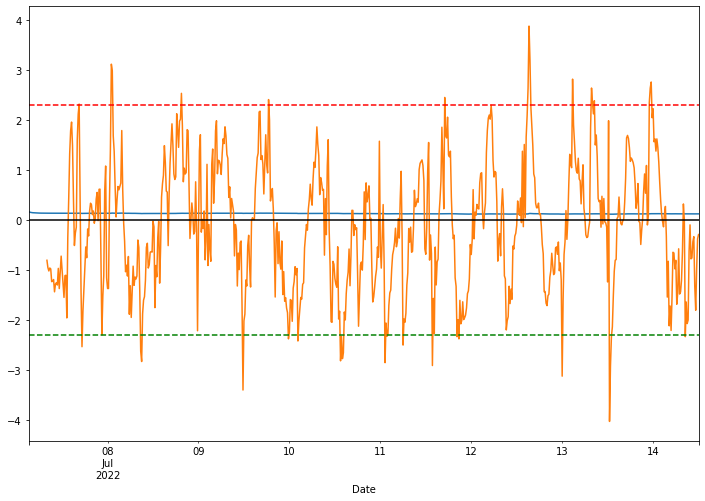

In [54]:
backtester.pair_results.spread.plot(figsize=(12,8))
backtester.pair_results.z_score.plot()
plt.axhline(0, color='black')
# plt.axhline(1, color='red', linestyle='--')
plt.axhline(2.3, color='red', linestyle='--')
# plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-2.3, color='green', linestyle='--')
# plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'], loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=labels)
plt.show()

In [60]:
# why long positions is not held between 13:15 - 00:00?
# it looks like it is, so plotting must be incorrect :thinking:
backtester.pair_results.loc["2022-07-13 12:00":"2022-07-14 00:00"].num_units

Date
2022-07-13 12:00:00   -1.0
2022-07-13 12:15:00   -1.0
2022-07-13 12:30:00   -1.0
2022-07-13 12:45:00   -1.0
2022-07-13 13:00:00   -1.0
2022-07-13 13:15:00    1.0
2022-07-13 13:30:00    1.0
2022-07-13 13:45:00    1.0
2022-07-13 14:00:00    1.0
2022-07-13 14:15:00    1.0
2022-07-13 14:30:00    1.0
2022-07-13 14:45:00    1.0
2022-07-13 15:00:00    1.0
2022-07-13 15:15:00    1.0
2022-07-13 15:30:00    1.0
2022-07-13 15:45:00    1.0
2022-07-13 16:00:00    1.0
2022-07-13 16:15:00    1.0
2022-07-13 16:30:00    1.0
2022-07-13 16:45:00    1.0
2022-07-13 17:00:00    1.0
2022-07-13 17:15:00    1.0
2022-07-13 17:30:00    1.0
2022-07-13 17:45:00    1.0
2022-07-13 18:00:00    1.0
2022-07-13 18:15:00    1.0
2022-07-13 18:30:00    1.0
2022-07-13 18:45:00    1.0
2022-07-13 19:00:00    1.0
2022-07-13 19:15:00    1.0
2022-07-13 19:30:00    1.0
2022-07-13 19:45:00    1.0
2022-07-13 20:00:00    1.0
2022-07-13 20:15:00    1.0
2022-07-13 20:30:00    1.0
2022-07-13 20:45:00    1.0
2022-07-13 21:00:00    

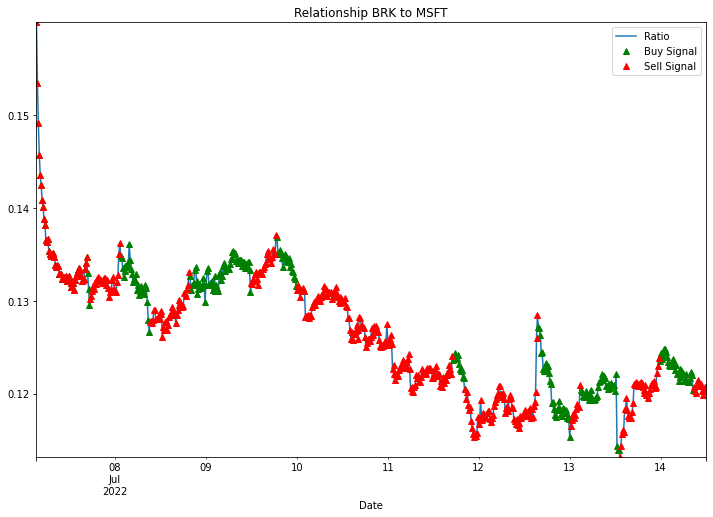

In [55]:
# figure(figsize=(8, 6), dpi=200)
backtester.pair_results.spread.plot(figsize=(12, 8))
buy = backtester.pair_results.spread.copy()
sell = backtester.pair_results.spread.copy()
buy[backtester.pair_results.num_units==1] = 0
sell[backtester.pair_results.num_units==-1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, backtester.pair_results.spread.min(), backtester.pair_results.spread.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')
plt.show()

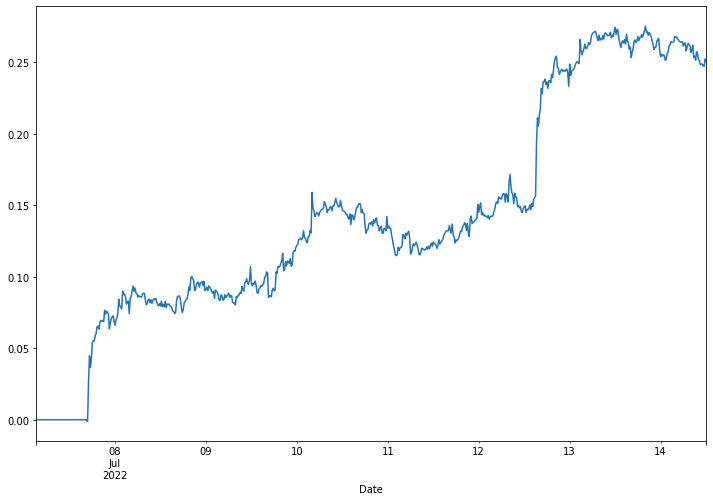

In [56]:
backtester.pair_results.net.plot(figsize=(12,8))
plt.show()

It looks like chart indicates position taken in reverse to intended.

In [28]:
backtester.pair_results

,CTKUSDT_FUTURES,CTKUSDT_FUTURES_returns,LINKBUSD_FUTURES,LINKBUSD_FUTURES_returns,AVAXUSDT_FUTURES,AVAXUSDT_FUTURES_returns,GALABUSD_FUTURES,GALABUSD_FUTURES_returns,FTTUSDT_FUTURES,FTTUSDT_FUTURES_returns,...,long_exit,num_units_long,short_entry,short_exit,num_units_short,num_units,dailyret,gross,trades,net
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-07 03:15:00,0.8868,-0.001803,6.349,-0.001102,19.26,-0.002593,0.054420,-0.001946,26.087,-0.001264,...,False,0.0,False,False,0.0,0.0,NaN,NaN,0.0,NaN
2022-07-07 03:30:00,0.8827,-0.004634,6.376,0.004244,19.37,0.005695,0.054502,0.001506,26.171,0.003215,...,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
2022-07-07 03:45:00,0.8826,-0.000113,6.376,0.000000,19.40,0.001548,0.054665,0.002986,26.167,-0.000153,...,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
2022-07-07 04:00:00,0.8795,-0.003519,6.354,-0.003456,19.30,-0.005168,0.054206,-0.008432,26.075,-0.003522,...,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
2022-07-07 04:15:00,0.8759,-0.004102,6.353,-0.000157,19.15,-0.007802,0.054225,0.000350,26.020,-0.002112,...,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-14 11:00:00,0.7793,-0.001667,6.046,-0.002973,18.00,-0.007196,0.047163,-0.001906,24.552,-0.001221,...,False,1.0,False,False,0.0,1.0,-0.000044,0.305673,0.0,0.268473
2022-07-14 11:15:00,0.7806,0.001667,6.027,-0.003148,17.94,-0.003339,0.046879,-0.006040,24.486,-0.002692,...,False,1.0,False,False,0.0,1.0,-0.001104,0.304569,0.0,0.267369
2022-07-14 11:30:00,0.7824,0.002303,6.032,0.000829,17.95,0.000557,0.046850,-0.000619,24.548,0.002529,...,False,1.0,False,False,0.0,1.0,-0.000504,0.304065,0.0,0.266865


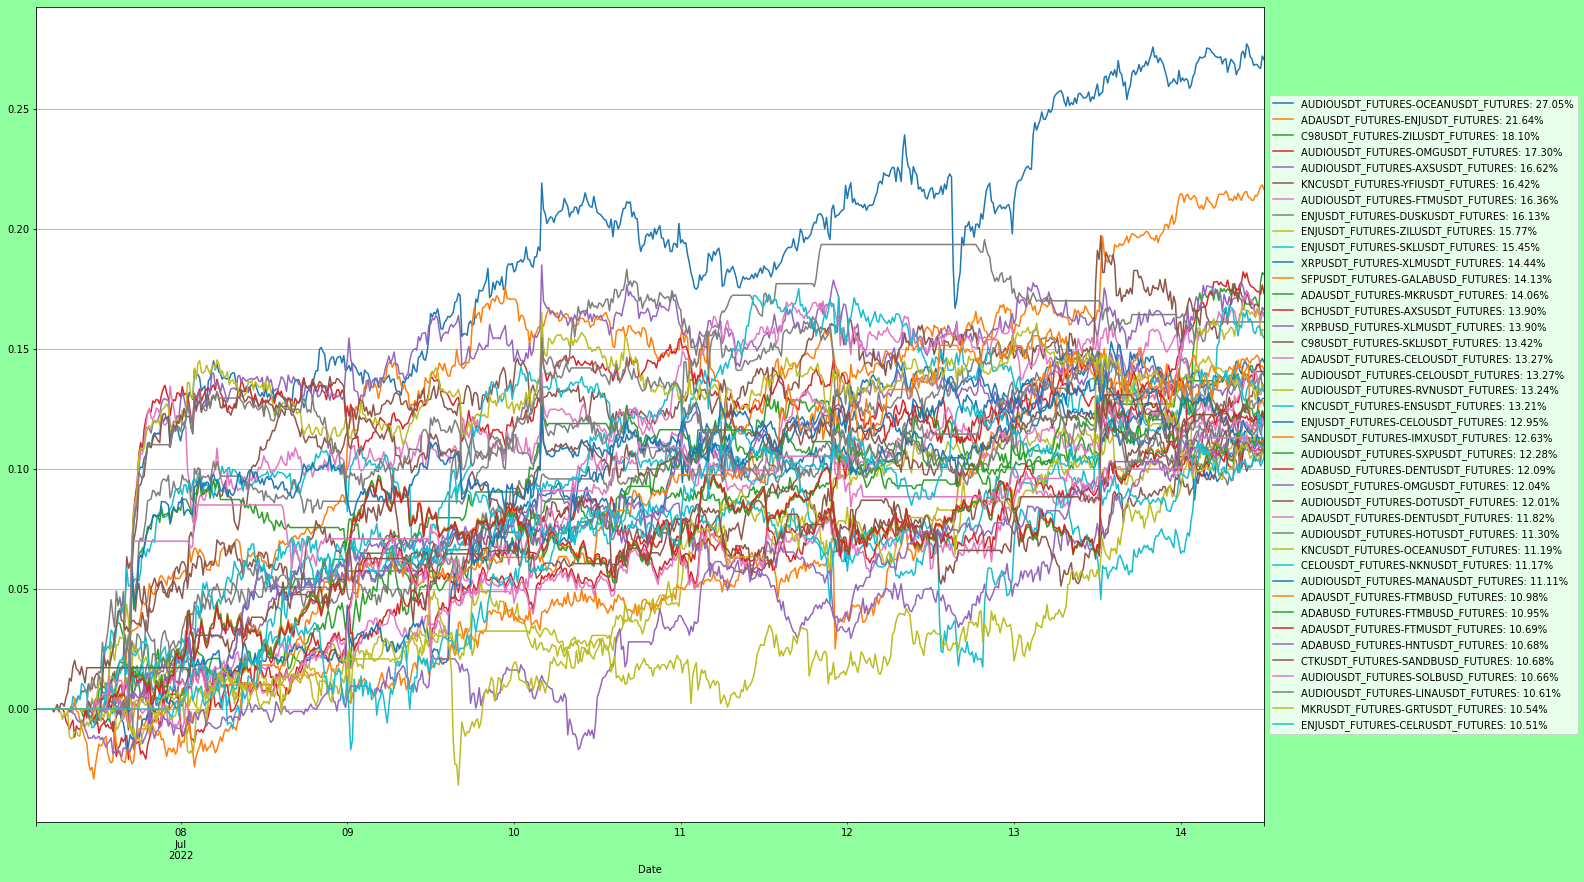

<Figure size 432x288 with 0 Axes>

In [55]:
backtester.pairs_results.iloc[:,:40].plot(figsize=(22,15), legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=labels)
plt.grid()
# plt.rcParams['figure.facecolor'] = 'xkcd:mint green'
fig = plt.figure()
fig.patch.set_facecolor('xkcd:mint green')
plt.savefig("backtest_15m_20d.png", edgecolor="white")
plt.show()

In [ ]:
backtester.optimize_pairs(z_entry_range=(1.3, 2.2), z_exit_range=(-1.2, 0))

In [16]:
backtester.pairs_results_opt_overview.to_csv("min_range_opt_binance_futures_20d_15m.csv")

In [142]:
df_opt = pd.read_csv("./processed_data/opt_overview_15m_sharpe_temp2022-08-03T02:58:58.csv", index_col=0)
df_opt

,opt_entry,opt_exit,net,sharpe
BTCUSDT_220930_FUTURES-ENSUSDT_FUTURES,1.4,-2.4,0.010221,1838.563695
BCHUSDT_FUTURES-KLAYUSDT_FUTURES,1.4,-2.4,0.007575,1698.035866
ZENUSDT_FUTURES-COTIUSDT_FUTURES,1.4,-2.4,0.009480,1671.424005
LTCUSDT_FUTURES-GRTUSDT_FUTURES,1.4,-2.4,0.004683,1564.718469
MKRUSDT_FUTURES-CVCUSDT_FUTURES,1.5,-2.1,0.007932,1471.438677
...,...,...,...,...
ETCUSDT_FUTURES-COTIUSDT_FUTURES,1.4,-2.4,0.000000,NaN
ENSUSDT_FUTURES-GRTUSDT_FUTURES,1.4,-2.4,0.000000,NaN
ETCUSDT_FUTURES-AXSUSDT_FUTURES,1.4,-2.4,0.000000,NaN
KAVAUSDT_FUTURES-KLAYUSDT_FUTURES,1.4,-2.4,0.000000,NaN


<h1>CORRELATION NET VS. GRANGER P</h1>

In [148]:
# df_opt['granger_sum'] = granger_sum
# df_opt.granger_sum.value_counts()
df_opt['ETHBUSD_FUTURES-ETHUSDT_FUTURES']

KeyError: 'ETHBUSD_FUTURES-ETHUSDT_FUTURES'

In [145]:
df_opt.head(60)

,opt_entry,opt_exit,net,sharpe,granger_sum
BTCUSDT_220930_FUTURES-ENSUSDT_FUTURES,1.4,-2.4,0.010221,1838.563695,NaN
BCHUSDT_FUTURES-KLAYUSDT_FUTURES,1.4,-2.4,0.007575,1698.035866,NaN
ZENUSDT_FUTURES-COTIUSDT_FUTURES,1.4,-2.4,0.009480,1671.424005,NaN
LTCUSDT_FUTURES-GRTUSDT_FUTURES,1.4,-2.4,0.004683,1564.718469,NaN
MKRUSDT_FUTURES-CVCUSDT_FUTURES,1.5,-2.1,0.007932,1471.438677,0.404122
MKRUSDT_FUTURES-ZILUSDT_FUTURES,1.4,-2.4,0.011822,1452.092791,0.728762
KSMUSDT_FUTURES-XRPBUSD_FUTURES,1.4,-2.4,0.003743,1444.803769,NaN
MKRUSDT_FUTURES-STORJUSDT_FUTURES,1.4,-2.4,0.019404,1436.208272,NaN
MKRUSDT_FUTURES-LPTUSDT_FUTURES,1.4,-2.4,0.008185,1364.112154,0.739435
BCHUSDT_FUTURES-FTMUSDT_FUTURES,1.4,-2.4,0.006036,1342.153023,NaN


<h2>EXAMPLES + PLOTTING IDEAS</H2>

In [ ]:
backtester.optimize_pair(z_entry_range=(1, 2.6), z_exit_range=(-1, 0.3), pair=["COMPUSDT_FUTURES", "GMTBUSD_FUTURES"])

In [ ]:
backtester.pair_results_opt_overview

In [101]:
backtester.backtest_pair(pair=["COMPUSDT_FUTURES", "GMTBUSD_FUTURES"], z_entry=1.9, z_exit=-1.9, rolling_z_score=True)

['COMPUSDT_FUTURES', 'GMTBUSD_FUTURES'] 1.9 -1.9


Date
2022-06-24 12:30:00         NaN
2022-06-24 12:45:00    0.000000
2022-06-24 13:00:00    0.000000
2022-06-24 13:15:00    0.000000
2022-06-24 13:30:00    0.000000
                         ...   
2022-07-14 11:00:00    0.477454
2022-07-14 11:15:00    0.480774
2022-07-14 11:30:00    0.483096
2022-07-14 11:45:00    0.482323
2022-07-14 12:00:00    0.481445
Name: net, Length: 1919, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

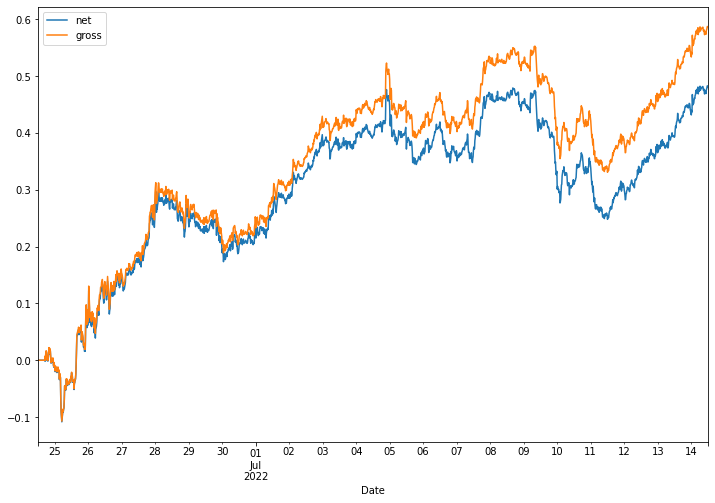

In [102]:
backtester.pair_results['net'].plot(figsize=(12, 8))
backtester.pair_results['gross'].plot(figsize=(12, 8))
plt.legend()
plt.show

In [103]:
backtester.pair_results

,COMPUSDT_FUTURES,COMPUSDT_FUTURES_returns,GMTUSDT_FUTURES,GMTUSDT_FUTURES_returns,GMTBUSD_FUTURES,GMTBUSD_FUTURES_returns,hr,spread,z_score,long_entry,long_exit,num_units_long,short_entry,short_exit,num_units_short,num_units,dailyret,gross,trades,net
Date,,,,,,,,,,,,,,,,,,,,
2022-06-24 12:30:00,43.37,-0.005289,0.8247,-0.007851,0.8237,-0.007258,-0.018085,0.039359,NaN,False,False,0.0,False,False,0.0,0.0,NaN,NaN,0.0,NaN
2022-06-24 12:45:00,43.12,-0.005781,0.8203,-0.005350,0.8191,-0.005600,-0.018274,0.031145,NaN,False,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
2022-06-24 13:00:00,43.21,0.002085,0.8194,-0.001098,0.8190,-0.000122,-0.018358,0.025742,NaN,False,False,0.0,False,False,0.0,0.0,-0.000000,0.000000,0.0,0.000000
2022-06-24 13:15:00,43.44,0.005309,0.8219,0.003046,0.8208,0.002195,-0.018400,0.021484,NaN,False,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
2022-06-24 13:30:00,43.54,0.002299,0.8220,0.000122,0.8209,0.000122,-0.018419,0.018932,NaN,False,False,0.0,False,False,0.0,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-14 11:00:00,47.94,-0.004163,0.8807,-0.005435,0.8800,-0.005553,-0.018009,0.016643,-1.393504,False,False,0.0,False,False,-1.0,-1.0,0.001390,0.581854,0.0,0.477454
2022-07-14 11:15:00,47.93,-0.000209,0.8778,-0.003298,0.8769,-0.003529,-0.018002,0.014076,-1.578631,False,False,0.0,False,False,-1.0,-1.0,0.003320,0.585174,0.0,0.480774
2022-07-14 11:30:00,48.14,0.004372,0.8791,0.001480,0.8787,0.002051,-0.017991,0.012623,-1.367259,False,False,0.0,False,False,-1.0,-1.0,0.002321,0.587496,0.0,0.483096


In [ ]:
backtester.pair_results_opt_overview.groupby("z_entry").sharpe.mean().plot()
plt.legend()
plt.show()
backtester.pair_results_opt_overview.groupby("z_exit").sharpe.mean().plot()
plt.legend()
plt.show()

In [ ]:
backtester.pair_results_opt_overview.groupby("z_entry").net.mean().plot()
plt.legend()
plt.show()
backtester.pair_results_opt_overview.groupby("z_exit").net.mean().plot()
plt.legend()
plt.show()

In [ ]:
# # for optimization I will probably need more simplified (df based) ver of the strategy
# # advanced tester below should be finished and revised
# def test_strategy_advanced(self, window=24, spread_entry=0.04, spread_exit=0.001, tp=0, sl=-0.04, critical_threshold = -2.4, unbiased_adf=True):
# inst1 = self.pair[0]
# inst2 = self.pair[1]

# data = self.data.copy()
# data["signals"] =  0
# data["%s_position" % inst1] = 0
# data["%s_position" % inst2] = 0
# data["gross_returns"] = 0
# data["net_returns"] = 0

# signal = 0
# old_signal = 0
# current_return = 0
# position0 = 0
# position1 = 0

# #moving through the sample
# for t in range(window, len(data)-1):
# df_adfuller = pd.DataFrame()

# # because of sampling index is off when sample[t]
# sample = data.iloc[t-window:t+1].copy()

# old_signal = signal
# old_position0 = position0
# old_position1 = position1
# gross = 0
# net = 0

# if unbiased_adf is True:
# def unit_root(b):
#     a = np.average(sample[inst2] - b*sample[inst1])
#     df_adfuller["fair_value"] = a + b*sample[inst1]
#     df_adfuller["diff_fair"] = df_adfuller["fair_value"] - sample[inst2]
#     df_adfuller["delta_diff_fair"] = df_adfuller["diff_fair"]/df_adfuller["diff_fair"].shift(1)
#     df_adfuller["lag_diff_fair"] = df_adfuller["diff_fair"].shift()
    
#     # LAGS (augmentation)
#     # df_adfuller["lag1_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(1)
#     # df_adfuller["lag2_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(2)
    
#     df_adfuller.dropna(inplace=True)
#     #OLS(dependent, independent)
#     reg = sm.OLS(df_adfuller["delta_diff_fair"], df_adfuller[["lag_diff_fair"]]) #, "lag1_delta_diff_fair", "lag2_delta_diff_fair"
#     res = reg.fit()
#     return res.params[0]/res.bse[0]
  
# # starting point
# reg = sm.OLS(np.array(sample[inst2]), sm.add_constant(sample[inst1]))
# res = reg.fit()
# b0 = res.params[1]

# # optimising the cointegration equation parameters - method most probably can be more performant one
# res1 = spop.minimize(unit_root, b0, method='Nelder-Mead')
# t_opt = res1.fun
# b_opt = float(res1.x)
# a_opt = np.average(sample[inst2] - b_opt*sample[inst1])

# # Z-Score based entries
# # sample["fair_value"] = a_opt + b_opt*sample[inst1]
# # sample["fair_spread"] = sample["fair_value"] - sample[inst2]
# # spread_mean = np.mean(sample["fair_spread"])
# # spread_std = np.std(sample["fair_spread"])
# # # investigate the curvature of the z_score in comparison to spread
# # sample["z_score"] = (sample["fair_spread"]-spread_mean)/spread_std
# else:
# print("BIASED ADFULLER")

# #simulating trading
# fair_value = a_opt + b_opt*sample[inst1].iloc[window]
# spread = fair_value - sample[inst2].iloc[window]

# # print(t, fair_value, spread, t_opt, signal)

# if t_opt > critical_threshold:
# signal = 0
# gross = 0
# else: 
# if old_signal == 0:
#   # pattern below is used in order to achieve result in % regarding the entry value
#   # abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry 
#   # spread in % ~ 
#   if abs(spread) > spread_entry: 
#     signal = np.sign(sample[inst2].iloc[window] - fair_value)
# elif old_signal != 0:
#   if sl != 0 and current_return < sl:
#     signal = 0
#   elif tp != 0 and current_return > tp:
#     signal = 0
#   elif abs(spread) <= spread_exit:
#     signal = 0
#   elif np.sign(fair_value - sample[inst2].iloc[window]) != old_signal:
#     if abs(spread) >= spread_entry:
#       signal = np.sign(sample[inst2].iloc[window] - fair_value)
#     else:
#       signal = 0
#   # below should be the equivalent (~) of
#   # elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
#   #   singal = old_signal
#   elif abs(spread) > spread_entry:
#     signal = np.sign(sample[inst2].iloc[window] - fair_value)
  
# position0 = signal
# position1 = -signal

# # gross = position0*(sample[inst1][t+1]/sample[inst1][t] - 1) + position1*(sample[inst2[1]][t+1]/sample[inst2[1]][t] - 1)
# gross = position0*sample["%s_returns" % inst1][window] + position1*sample["%s_returns" % inst2][window]
# net = gross - self.tc*(abs(position0 - old_position0) + abs(position1 - old_position1))
# if signal == old_signal:
#   current_return = (1+current_return)*(1+gross)-1
# else:
#   current_return = gross

# # data is not assigned correctly or sth

# # adfuller data could also be assigned below
# data.loc[[data.index[t]], ["%s_position" % inst1]] = position0
# data.loc[[data.index[t]], ["%s_position" % inst2]] = position1
# data.loc[[data.index[t]], ["gross_returns"] ] = gross
# data.loc[[data.index[t]], ["net_returns"]] = net

# #interface: reporting daily positions and realised returns
# print('day '+str(data.index[t]), t, "/", len(data)-1)
# print('')
# if signal == 0:
#     print('no trading')
# elif  signal == 1:
#     print('long position on '+inst2+' and short position on '+inst1)
# else:
#     print('long position on '+inst1+' and short position on '+inst2)
# print('gross daily return: '+str(round(gross*100,2))+'%')
# print('net daily return: '+str(round(net*100,2))+'%')
# print('cumulative net return so far: '+str(round(np.prod(1+data["net_returns"])*100-100,2))+'%')
# print('')

# results = data

# #plotting equity curves
# # plt.plot(np.append(1,np.cumprod(1+data["gross_returns"])))
# # plt.plot(np.append(1,np.cumprod(1+data["net_returns"])))